# MONAN new PBL scheme Evaluation
**The YSU PBL scheme was duplicated as "Taylor", but every internal stll the same. So, the outputs should remain exactly the same.**

---
### Libraries Used in This Notebook

matplotlib => Core Python plotting library used for generating static, animated, and interactive visualizations. <br>
matplotlib.tri.Triangulation => Module for handling unstructured grids through Delaunay triangulation. <br>
matplotlib.pyplot => State-based interface to Matplotlib, similar in style to MATLAB plotting. <br>
xarray => Library for working with labeled, multi-dimensional arrays. <br>
numpy => Fundamental numerical computing library in Python. <br>
cartopy => Library for geospatial data processing and map projections. <br>
cartopy.crs => Coordinate Reference System (CRS) module within Cartopy. <br>
cartopy.feature => Provides predefined geographic features.

In [1]:
from matplotlib.tri import Triangulation
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import cartopy
cartopy.config['data_dir'] = '/home2/eduardo.eras/workspace/python/cartopy_data'


---
### Load data
Load the reference monan YSU data and the Taylor modified data.

In [5]:
taylor_path = "/p/projetos/monan_atm/eduardo.eras/PBL_dev/output/2025112600_taylor/Model/MONAN_DIAG_G_MOD_GFS_2025112600_2025112612.00.00.x655362L55.nc"
ysu_path = "/p/projetos/monan_atm/eduardo.eras/PBL_dev/output/2025112600_YSU/Model/MONAN_DIAG_G_MOD_GFS_2025112600_2025112612.00.00.x655362L55.nc"

taylor_data = xr.open_dataset(taylor_path, engine = "netcdf4")
ysu_data = xr.open_dataset(ysu_path, engine = "netcdf4")
difference_data = xr.Dataset(
    {
        "t2m": taylor_data["t2m"] - ysu_data["t2m"],
        "lonCell": taylor_data["lonCell"],
        "latCell": taylor_data["latCell"]
    },
    coords = taylor_data.coords,
    attrs=taylor_data.attrs
)

taylor_monan_lons = taylor_data['lonCell']
taylor_monan_lats = taylor_data['latCell']
ysu_monan_lons = ysu_data['lonCell']
ysu_monan_lats = ysu_data['latCell']
difference_monan_lons = difference_data['lonCell']
difference_monan_lats = difference_data['latCell']

#Visualize the variables in the dataset
#list(taylor_data.data_vars)
#list(ysu_data.data_vars)

---
### Building the triangulation (unstructured MONAN grid)

MONAN provides horizontal grid coordinates (`lonCell`, `latCell`) in **radians**.
However, Cartopy map projections expect **longitude and latitude in degrees**.

The steps below:
1. Convert MONAN cell-center coordinates from radians to degrees
2. Build a triangulation in degree space
3. Use this triangulation for geographic plotting

This ensures that the unstructured grid is correctly positioned on the Earth.

In [6]:
# Convert coordinates from radians to degrees
taylor_monan_lons_deg = np.degrees(taylor_monan_lons.values)
taylor_monan_lats_deg = np.degrees(taylor_monan_lats.values)
ysu_monan_lons_deg = np.degrees(ysu_monan_lons.values)
ysu_monan_lats_deg = np.degrees(ysu_monan_lats.values)
difference_lons_deg = np.degrees(difference_monan_lons.values)
difference_lats_deg = np.degrees(difference_monan_lats.values)

# Build triangulation with degree coordinates
taylor_tri = Triangulation(taylor_monan_lons_deg, taylor_monan_lats_deg)
ysu_tri = Triangulation(ysu_monan_lons_deg, ysu_monan_lats_deg)
difference_tri = Triangulation(difference_lons_deg, difference_lats_deg)

In [7]:
#What's on my data
taylor_field = taylor_data["t2m"].isel(Time=0)
ysu_field = ysu_data["t2m"].isel(Time=0)
difference_field = difference_data["t2m"].isel(Time=0)  

print(taylor_field.min().item(), taylor_field.max().item())
print(taylor_field.mean().item())
print(ysu_field.min().item(), ysu_field.max().item())
print(ysu_field.mean().item())
print(difference_field.min().item(), difference_field.max().item())
print(difference_field.mean().item())

224.6793212890625 312.8403015136719
286.8405456542969
224.6793212890625 312.8403015136719
286.8405456542969
0.0 0.0
0.0


---
### Creating and rendering a georeferenced map of a MONAN diagnostic field

This block creates a georeferenced map using Cartopy and Matplotlib and
renders a MONAN diagnostic variable on its native unstructured grid.

The steps performed are:

1. **Create a Cartopy map axes**:
   A Matplotlib figure and axes are created using the `PlateCarree`
   projection, which assumes longitude and latitude expressed in degrees.
   This projection is appropriate because the MONAN cell-center coordinates
   have been converted from radians to degrees.

2. **Define the geographic extent**:
   The map domain is restricted to the MONAN model domain by computing the
   minimum and maximum longitude and latitude values of the cell centers.
   This ensures the plot is focused on the simulated region.

3. **Add geographic reference features**:
   Coastlines and international borders are added to provide spatial context.
   Gridlines with latitude and longitude labels are drawn to aid orientation
   and interpretation.

4. **Plot the diagnostic field on the unstructured grid**:
   The selected MONAN variable is plotted using a triangular mesh
   (`Triangulation`) that represents the native unstructured grid.
   Each triangle corresponds to a model cell and is colored according to the
   cell-centered value at the selected time.

5. **Attach a colorbar**:
   A colorbar is added to relate the color shading to physical values of the
   plotted variable.

This approach visualizes the model output in its native grid without
interpolation or remapping, making it suitable for diagnostic and exploratory
analysis.

In [8]:
def plot_field_on_map(tri, data, title):
    #Create a Cartopy map axes with Robinson projection
    fig, ax = plt.subplots(
        figsize=(15, 12),
        subplot_kw=dict(projection=ccrs.PlateCarree())
    )

    #Use global extent for Robinson projection
    ax.set_global()

    #Add geographic reference features
    ax.add_feature(
        cfeature.COASTLINE,
        linewidth=1.0,
        zorder=10
    )

    ax.add_feature(
        cfeature.BORDERS,
        linewidth=0.5,
        zorder=10
    )

    ax.gridlines(draw_labels=True)

    #Plot the diagnostic field on the unstructured grid
    tpc = ax.tripcolor(
        tri,
        data["t2m"].isel(Time=0),
        cmap="RdYlBu_r",
        shading="flat",
        transform=ccrs.PlateCarree()
    )

    #Attach a colorbar
    plt.colorbar(
        tpc,
        label="var label",
        shrink=0.5,
        aspect=25,
        pad=0.07
    )

    #Set the title
    ax.set_title(title)

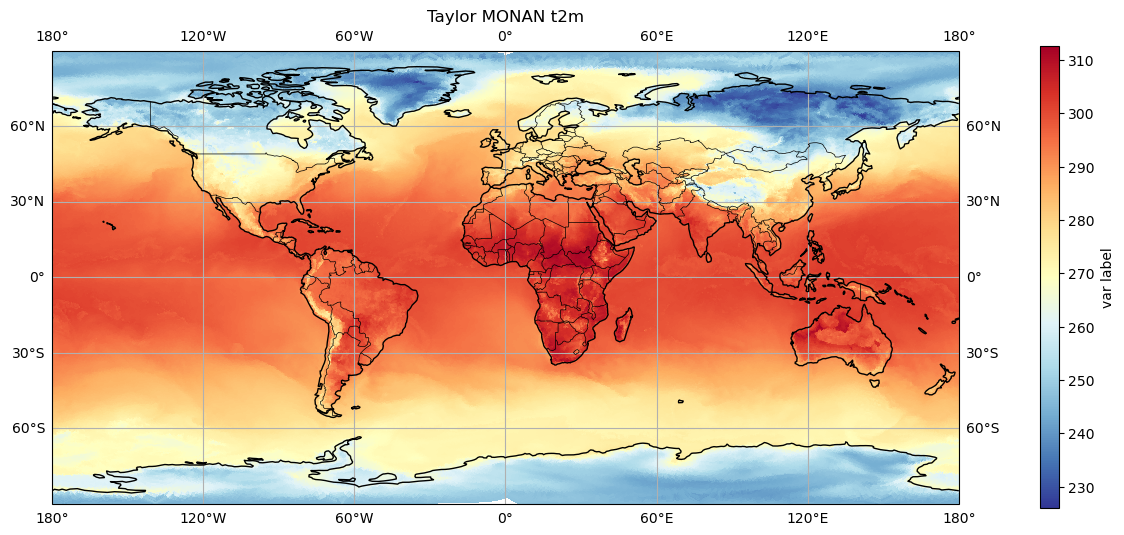

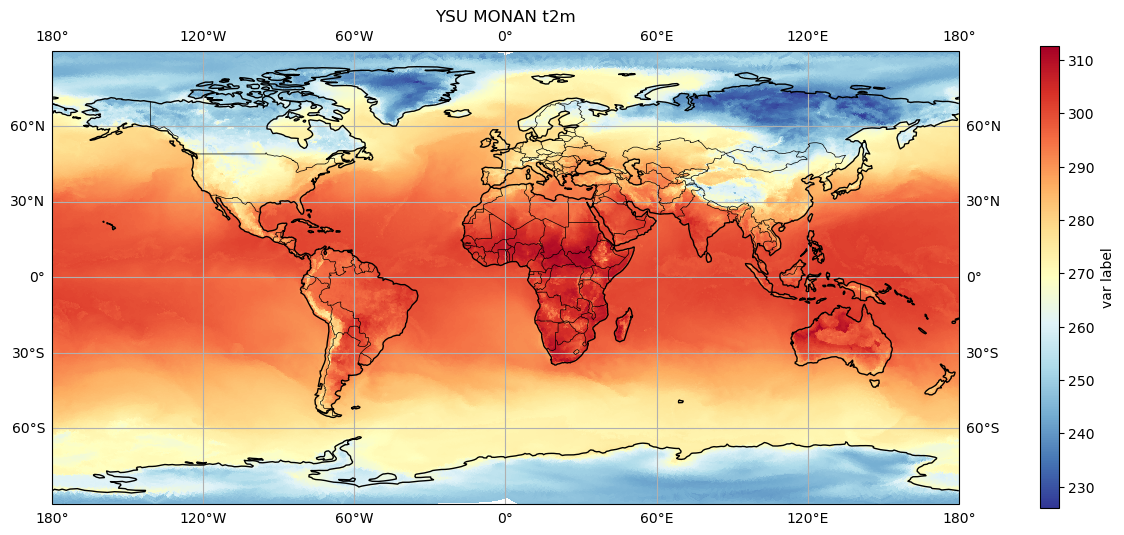

In [9]:
plot_field_on_map(taylor_tri, taylor_data, "Taylor MONAN t2m")
plot_field_on_map(ysu_tri, ysu_data, "YSU MONAN t2m")

---
### Difference Map
Let's plot the difference between the two maps by simple a - b.

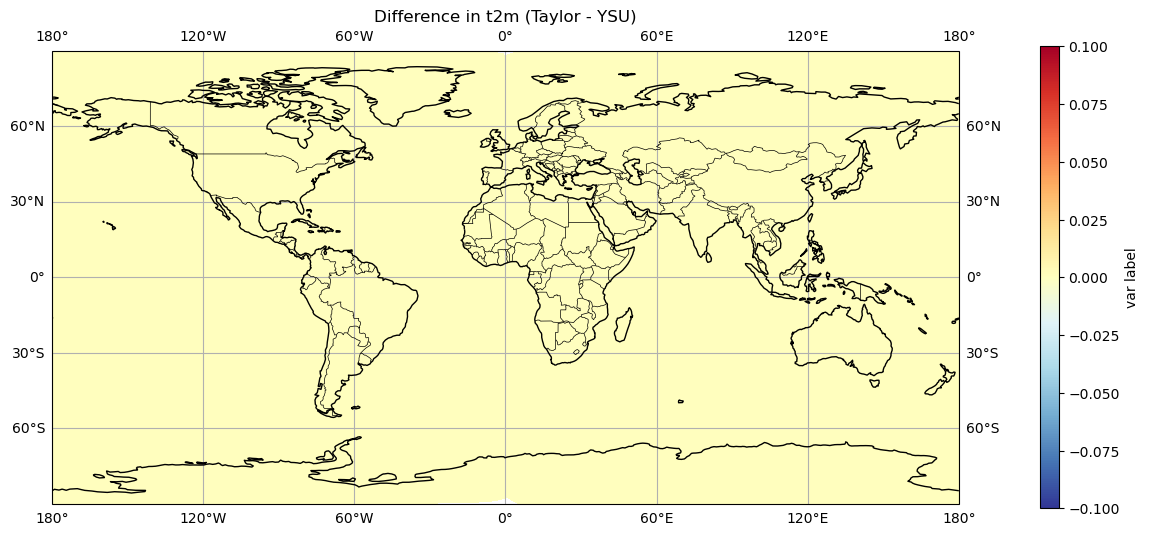

In [10]:
plot_field_on_map(difference_tri, difference_data, "Difference in t2m (Taylor - YSU)")

---
### Diagnose section

Checks Natural Earth coastline data availability and its directory path integrity.

In [12]:
import cartopy.io.shapereader as shapereader
import os

# Check data coordinate ranges
print("Data coordinate ranges:")
print(f"Longitude: min={taylor_monan_lons.min().values:.2f}, max={taylor_monan_lons.max().values:.2f}")
print(f"Latitude: min={taylor_monan_lats.min().values:.2f}, max={taylor_monan_lats.max().values:.2f}")

# Check what features are available
print("\nAvailable features:")
print(f"COASTLINE: {cfeature.COASTLINE}")
print(f"BORDERS: {cfeature.BORDERS}")

# Try to load the actual shapefiles
print("\nTrying to load Natural Earth data:")
try:
    coast_path = shapereader.natural_earth('110m', 'physical', 'coastline')
    print(f"110m coastline: {coast_path}")
    print(f"  File exists: {os.path.exists(coast_path)}")
except Exception as e:
    print(f"  110m Error: {e}")

try:
    boundary_path = shapereader.natural_earth('110m', 'cultural', 'admin_0_boundary_lines_land')
    print(f"110m boundaries: {boundary_path}")
    print(f"  File exists: {os.path.exists(boundary_path)}")
except Exception as e:
    print(f"  110m Error: {e}")


Data coordinate ranges:
Longitude: min=0.00, max=6.28
Latitude: min=-1.57, max=1.57

Available features:
COASTLINE: <cartopy.feature.NaturalEarthFeature object at 0x7fd809230260>
BORDERS: <cartopy.feature.NaturalEarthFeature object at 0x7fd8093f7650>

Trying to load Natural Earth data:
110m coastline: /home2/eduardo.eras/workspace/python/cartopy_data/shapefiles/natural_earth/physical/ne_110m_coastline.shp
  File exists: True
110m boundaries: /home2/eduardo.eras/workspace/python/cartopy_data/shapefiles/natural_earth/cultural/ne_110m_admin_0_boundary_lines_land.shp
  File exists: True
